---
toc: true
layout: post
description: 6장
categories: [statistics,python]
title: 통계분석1 (Linear Regression)
---

<!-- [kaggle/GREG HAMEL/Hypothesis Testing](https://www.kaggle.com/hamelg/python-for-data-24-hypothesis-testing) -->

---

# 06_통계분석_1

# 회귀분석
- 독립변수의 값이 주어졌을 때 종속변수의 값을 예측하거나, 독립변수와 종속변수간의 인과관계를 검증할 수 있는 통계분석 기법<br>
  ex) 아파트의 방 개수, 방 크기, 주변 학군 등 여러 개의 독립변수에 따라 아파트 가격이라는 종속변수가 어떤 관계를 나타내는지를 모델링하고 예측 또는 광고의 횟수와 매출액의 관계나 구매유형에 따른 고객만족도와 같은 관계 등을 파악


## 회귀 유형 : 회귀 계수의 선형/비선형 여부, 독립변수의 개수, 종속변수의 개수에 따라 나뉨<br>
  ㄱ. 독립변수의 수<br>
  단순회귀 : 독립변수와 종속변수가 각각 한개씩이면서 모두 수치형<br>
  다중회귀 : 1개의 수치형 종속변수와 2개 이상의 독립변수(수치형 또는 범주형)<br>
  ㄴ. 독립변수의 척도<br>
  일반회귀 : 등간, 비율척도<br>
  더미변수를 이용한 회귀 : 명목, 서열척도<br>
  ㄷ. 독립변수와 종속변수의 관계<br>
  선형회귀 : 선형<br>
  비선형회귀 : 비선형      
  
  
### 선형 회귀 : 실제 값과 예측값의 차이, 즉 RSS(Residual Sum of Squares)를 최소화하는 직선형 회귀선을 최적화하는 방식<br>
  규제가 없는 일반 선형 회귀, 선형 회귀에 L1 규제를 추가한 라쏘(Lasso) 회귀, L2 규제를 추가한 릿지(Ridge) 회귀, L1/L2규제를 결합한 엘라스틱넷(ElasticNet) 회귀, 분류에 사용되는 선형 모델인 로지스틱 회귀(Logistic Regression)
  
  
## 전제조건(가정)<br>
  **선형성(선형회귀에 한함)** : 독립변수와 종속변수 간에는 선형관계가 존재<br>
  일부가 선형성을 만족하지 않는다면, 일단 선형 회귀모델을 만들고 변수 선택법으로 처리하거나, 다른 새로운 변수를 추가해보거나, 선형성을 만족하지 않는 변수를 제거하거나, 로그/지수/루트 등 변수 변환하는 방법으로 처리<br>
  **등분산성** : 잔차들은 동일한 분산을 가짐, 분산이 같다는 것은 특정한 패턴 없이 고르게 분포했다는 의미<br>
  **독립성(다중회귀에 해당)** : 잔차들은 서로 독립(독립변수 x 간에 상관관계가 없이 독립성을 만족)<br>
  Stepwise를 사용해서 다중공선성을 일으키는 변수들을 제거하는 방법으로 처리<br>
  **정규성** : 잔차가 정규분포를 따름. Shapiro-Wilk Test로 확인


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# print를 하지 않아도 행을 모두 보여줌
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Columns를 생략 없이 모두 보여줌
from IPython.display import display
pd.options.display.max_columns = None


## [ sklearn package의 LinearRegression Class ]
- **예측값과 실제값의 RSS(Residual Sum of Squares)를 최소화해 OLS(Ordinary Least Squares, 최소제곱법)** 추정 방식으로 구현한 클래스
- 따라서, 수렴할 때까지 얼마나 반복할 것인지(num_iterations), 얼마나 꼼꼼히 학습할 것인지(learning_rate) 이런 것들을 복잡하게 고려하지 않아도 됨
- 단, OLS기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받음. 피처간의 상관관계까 매우 높은 경우 분산이 매추 커져서 오류에 매우 민감해짐 <- 이러한 현상을 **다중공선성(multi-collinearity) 문제**라고 함<br>
  상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 **제거하거나 규제를 적용**함. 또한 PCA를 통해 **차원 축소**를 수행하는것도 고려해볼 수 있음


- library load<br>
  **from sklearn.linear_model import LinearRegression**<br>


- LinearRegression Class는 fit() method로 X, y 배열을 입력받으면 회귀 계수(Coefficients)인 W를 coef_속성에 저장함


- LinearRegression 모델을 생성하고<br>
    line_fitter = LinearRegression()                    <-- 모형에 상수항(절편)이 있으면 True<br>
    line_fitter = LinearRegression(fit_intercept=False) <-- 모형에 상수항(절편)이 없으면 False로<br>
    ※ fit_intercept : default TRUE, 절편(intercept)값 계산여부를 지정함. False로 지정하면 0으로 지정됨<br>
    ※ normalize : default FALSE, fit_intercept가 False인 경우에는 이 파라미터 무시됨. True로 지정하면 회귀 수행 전 입력 데이터셋을 정규화함


- 그 안에 X, y 데이터를 fit함<br>
  fit() 메서드는 선형 회귀 모델에 필요한 두 가지 변수를 전달하는 것<br>
    line_fitter.fit(X, y)<br>
  이렇게 하면 새로운 X 값을 넣어 y값을 예측할 수 있음<br>
    y_predicted = line_fitter.predict(X)<br>
  
  
- 기울기(회귀계수) 확인 : line_fitter.coef_
- 절편 확인 : line_fitter.intercept_

## [ statsmodels package의 formula.api Module ]

- **import statsmodels.formula.api as smf**


- 회귀분석을 지원하는 ols() 함수 : ols(formula='종속변수 ~ 독립변수', data=data1)<br>
  model_smf = smf.ols(formula='height ~ weight', data = body).fit()


- 분석 결과 확인<br>
  model_smf.summary()<br>
  결과 해석은 아래 단순회귀 참조

### [ 회귀 평가 지표 ]
- **MAE(Mean Absolute Error) : 실제값과 예측값의 차이를 절댓값으로 변환해 평균한 것**<br>
  사이킷런 평가지표 API : metrics.mean_absolute_error<br>
  Scoring 함수 적용 값 : 'neg_mean_absolute_error'


- **MSE(Mean Squared ERror, 평균제곱오차) : 실제값과 예측값의 차이를 제곱해 평균한 것**<br>
  전체 에러를 표현하기 위해서 사용, 부호로 인한 오차를 의미를 없애고자 오차에 제곱<br>
  오차의 제곱에 대해 평균을 취한 것, **수치가 작을수록 원본과의 오차가 적은 것**<br>
  사이킷런 평가지표 API : metrics.mean_squared_error<br>
  scoring="neg_mean_squared_error" : 접두어 neg_는 Negative(음수)값을 가진다는 의미로, cross_val_score()의 인자로 scoring="neg_mean_squared_error"를 지정해 음수값을 반환하는 이유는 사이킷런의 Scoring함수가 score값이 클수록 좋은 평가 결과로 자동 평가하기 때문<br>
  이 인자를 지정한 경우 반환되는 음수 값에 -1을 곱해서 양의 값으로 변경하여 출력<br>
  mse = mean_squared_error(y_test, y_preds)<br>
  print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))


- **RMSE(Root Mean Squared Error, 평균제곱근오차) : MSE에 루트를 씌운 것**<br>
  MSE값은 오류의 제곱을 구하므로 실제 오류 평균보다 더 커지는 특성이 있으므로<br>
  특정 수치에 대한 예측의 정확도를 표현할 때, Accuracy로 판단하기에는 정확도를 올바르게 표기할 수 없어, RMSE 수치로 정확도를 판단함<br>
  일반적으로 **해당 수치가 낮을수록 정확도가 높다**고 판단<br>
  사이킷런에서 제공하지 않음. MSE에 제곱근을 씌워서 계산하는 함수를 직접 만들어야함<br>
  rmse = np.sqrt(mse)


- **R2** : 분산 기반으로 예측 성능을 평가함. 실제값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높음<br>
  **확인필요** R2는 적합된 회귀선의 설명력 아니었나? 예측 정확도와 같음?
  사이킷런 평가지표 API : metrics.r2_score<br>
  Scoring 함수 적용 값 : 'r2'<br>
  print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

## 1. 단순회귀분석
- 종속변수(수치형)를 하나의 독립변수(수치형)로 설명하는 것
- y ~ X1

In [2]:
# 예제 데이터셋
height = [170, 168, 177, 181 ,172, 171, 169, 175, 174, 178, 170, 167, 177, 182 ,173, 171, 170, 179, 175, 177, 186, 166, 183, 168]
weight = [70, 66, 73, 77, 74, 73, 69, 79, 77, 80, 74, 68, 71, 76, 78, 72, 68, 79, 77, 81, 84, 73, 78, 69]

body = pd.DataFrame(
    {'height': height,
    'weight': weight
    }
)
body.head(3)

,height,weight
0,170,70
1,168,66
2,177,73


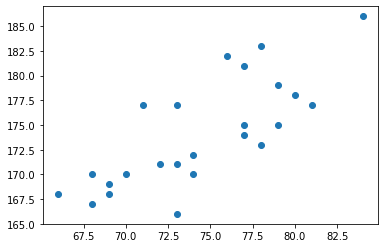

In [3]:
plt.plot(body['weight'], body['height'], 'o')
plt.show()

### 1-1) LinearRegression

In [4]:
# 단순 선형 회귀 모델

import numpy as np
from sklearn.linear_model import LinearRegression

# X데이터를 넣을 때 .values.reshape(-1,1) 이유 : X는 2차원 array 형태여야 하기 때문, 차원증가
X = body['weight'].values.reshape(-1,1) #단순회귀일 때는 reshape 필수
y = body['height']

model = LinearRegression()
model.fit(X, y)

print('R2 : ', model.score(X, y))  # 1에 가까울수록 설명력이 높은데... 0.589

print('회귀계수 :',model.coef_)

print('절편 : ', model.intercept_)

# y = 107.86 + 0.89x

LinearRegression()

R2 :  0.5893075473608536
회귀계수 : [0.89042657]
절편 :  107.86242266362746


In [7]:
# 예측

# print(np.array([80, 70, 100]))
# print(new)
new = np.array([80, 70, 100]).reshape(-1,1) # predict할 때도 reshape 필수
model.predict(new)

array([179.09654836, 170.19228264, 196.90507978])

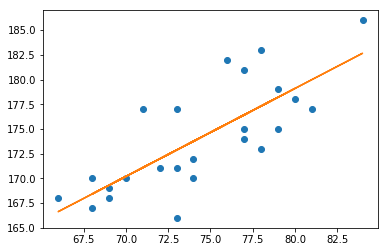

In [9]:
# 모델 시각화

plt.plot(X, y, 'o')
plt.plot(X,model.predict(X))
plt.show()

### 1-2) statsmodels - formula.api

In [8]:
# statsmodels package 사용
import statsmodels.formula.api as smf

# 단순회귀분석 실행하고 분석결과 출력
# 회귀분석을 지원하는 ols() 함수 : ols(formula='종속변수 ~ 독립변수', data=data1)
model_smf = smf.ols(formula='height ~ weight', data = body).fit()
model_smf.summary()

# 첫번째 테이블 : 수행된 회귀분석 결과의 일반적인 사항을 요약함
    # 종속변수(Dep.Variable), 분석모델(Model), Model의 계산방식(Method)
    # F-statistic : 해당 회귀모형의 적합도를 나타내는 통계량
    # F검정통계량의 유의 확률(Prob(F-statistic) : 1.20e-05로 유의확률이 0.01이하이므로 본 회귀모형은 유의미함
    # 모형의 결정계수(R-squared) 즉 설명력은 0.589 수준으로 나타남
    # 잔차의 자유도(Df Residuals)는 22, 모형의 매개변수 수(DF Model)는 1
    # AIC와 BIC는 복수개 모형의 적합도를 비교할 때 사용하는데 일반적으로 해당 통계량이 작을수록 더 좋은 모형이라고 판단함
      # (이 예제는 1개의 모형만 사용했으므로 해당사항 없음)
# 두번째 테이블 : 모형에 의해 추정된 회귀계수 테이블
    # 계수 추정치의 기본 표준오차(std err), t-value(t), 유의확률(P>|t|)
    # 95% 신뢰구간의 하한/상한값 제시
    # 분석결과 절편(intercept)과 독립변수인 weight는 모두 유의미하게 나타남(0.000???)
# 세번째 테이블 : 잔차의 분포를 평가하기 위한 몇가지 통계량을 보여줌
    # Omnibus : 잔차의 왜도와 첨도를 이용한 검정 통계량으로 0에 가까운 값이 나올수록 정규분포를 따른다고 판단
    # Prob(Omnibus) : Omnibus의 p-value임. 귀무가설로써 정규분포인지 평가함
    # Jarque-Bera(JB)/Prob(JB) : Omnibus와 유사하게 잔차의 왜도와 첨도를 이용해 정규성을 검정하는 통계량
    # 왜도(Skew), 첨도(Kurtosis)
    # Durbin-Watson : 회귀분석 시 잔차의 독립성을 검증할 때 사용하는 통계량. 보통 0~4 값이 출력되며 2에 가까울수록 독립적이라고 판단
    # Cond. No.(Condition Number) : 다중공선성을 평가할 수 있는 통계량. 30보다 작으면 다중공선성이 없다고 판단함
      # (이 예제는 하나의 독립변수만 사용했으므로 해당없음)    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     31.57
Date:                Sat, 27 Nov 2021   Prob (F-statistic):           1.20e-05
Time:                        21:14:49   Log-Likelihood:                -63.655
No. Observations:                  24   AIC:                             131.3
Df Residuals:                      22   BIC:                             133.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    107.8624     11.816      9.128      0.000      83.357     132.368
weight         0.8904      0.158      5.619      0.000       0.562       1.219
==============================================================================
Omnibus:                        0.796   Durbin-Watson:                   2.201
Prob(Omnibus):                  0.672   Jarque-Bera (JB):                0.829
Skew:                           0.329   Prob(JB):                        0.661
Kurtosis:                       2.371   Cond. No.                     1.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2. 다중회귀분석
- X가 두 개 이상
- 종속변수(1개)는 수치형이고, 독립변수는 수치형이거나 범주형일 수 있음, 범주형 변수는 더미변수로 전환하여 사용

In [9]:
# 예제 데이터셋

X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])

print('X :\n', X)

# y = ( ( x_0 * 1 ) + ( x_1 * 2 ) ) + 3
y = np.dot(X, np.array([1, 2])) + 3

print('\ny :\n', y)

X :
 [[1 1]
 [1 2]
 [2 2]
 [2 3]]

y :
 [ 6  8  9 11]


### 2-1) 교호작용을 고려하지 않을 때

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression

#model = LinearRegression()
#model.fit(X, y)
model = LinearRegression().fit(X, y)

print('R2 : ', model.score(X, y))
print('회귀계수 :',model.coef_)
print('절편 : ', model.intercept_)

# 예측
print(model.predict(np.array([[3, 5]]))) # 정수가 아니라 실수로 출력되네

R2 :  1.0
회귀계수 : [1. 2.]
절편 :  3.0000000000000018
[16.]


### 2-2) 교호작용을 고려할 때
- 교호작용(Interaction) : 한 요인의 효과가 다른 요인의 수준에 의존하는 경우

- 두 인자 A, B 간에는 교호작용이 없음 : A의 효과가 B의 서로 다른 수준 B1과 B2에서 일관성 있게 나타날 때
- 두 인자 A, B 간에 교호작용이 존재함 : B가 ‘B1수준에 있을 때 A의 효과’와 ‘B2수준에 있을 때 A의 효과’간에 차이가 있을 때


- X1, X2, X3가 있을 때 2차 교호작용 변수는 두 개 변수까지 곱하는 것, 3차는 세 개까지의 조합
- 제곱을 하는 것은 교호가 아니라 다항의 개념
- 교호작용도를 사용하여 가능한 교호작용을 시각화할 수 있다. 교호작용도가 평행선으로 나타나면 교호작용이 없다는 것을 나타낸다.

In [11]:
# 맛보기(다항회귀에서 상세하게)
from sklearn.preprocessing import PolynomialFeatures

poly_d2 = PolynomialFeatures(degree=2, interaction_only=True)
# degree = 2 는 2차까지 만든다는 뜻, X3까지 있으면 degree=3도 가능할 듯
# interaction = True는 교호작용 변수만 만들고, 다항(제곱) 변수는 만들지 않겠다는 것
X_poly = poly_d2.fit_transform(X)

X_poly    # 1, X1, X2, X1*X2 순

array([[1., 1., 1., 1.],
       [1., 1., 2., 2.],
       [1., 2., 2., 4.],
       [1., 2., 3., 6.]])

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_poly, y)

print('R2 : ', model.score(X_poly, y))
print('회귀계수 :',model.coef_)
print('절편 : ', model.intercept_)

# 예측
print(model.predict(np.array([[1, 3, 5, 15]])))

R2 :  1.0
회귀계수 : [ 0.00000000e+00  1.00000000e+00  2.00000000e+00 -1.55360188e-15]
절편 :  2.9999999999999964
[16.]


### 2-3) 다중회귀분석 예시 : 집값 예측

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이터셋 로드
boston = load_boston()

boston

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [14]:
# boston 데이터셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [15]:
# boston dataset의 target array는 주택 가격. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target

print('Boston 데이터셋 크기 :', bostonDF.shape, '\n')   # 506 rows, 14 cols
print('Boston 데이터셋 정보 :', bostonDF.info())        # Null 없음. 14 cols 모두 float type
bostonDF.head()

Boston 데이터셋 크기 : (506, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB
Boston 데이터셋 정보 : None


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


* CRIM: 지역별 범죄 발생률  
* ZN: 25,000평방피트를 초과하는 거주 지역의 비율
* NDUS: 비상업 지역 넓이 비율
* CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX: 일산화질소 농도
* RM: 거주할 수 있는 방 개수
* AGE: 1940년 이전에 건축된 소유 주택의 비율
* DIS: 5개 주요 고용센터까지의 가중 거리
* RAD: 고속도로 접근 용이도
* TAX: 10,000달러당 재산세율
* PTRATIO: 지역의 교사와 학생 수 비율
* B: 지역의 흑인 거주 비율
* LSTAT: 하위 계층의 비율
* MEDV: 본인 소유의 주택 가격(중앙값)

<AxesSubplot:xlabel='RM', ylabel='PRICE'>

<AxesSubplot:xlabel='ZN', ylabel='PRICE'>

<AxesSubplot:xlabel='INDUS', ylabel='PRICE'>

<AxesSubplot:xlabel='NOX', ylabel='PRICE'>

<AxesSubplot:xlabel='AGE', ylabel='PRICE'>

<AxesSubplot:xlabel='PTRATIO', ylabel='PRICE'>

<AxesSubplot:xlabel='LSTAT', ylabel='PRICE'>

<AxesSubplot:xlabel='RAD', ylabel='PRICE'>

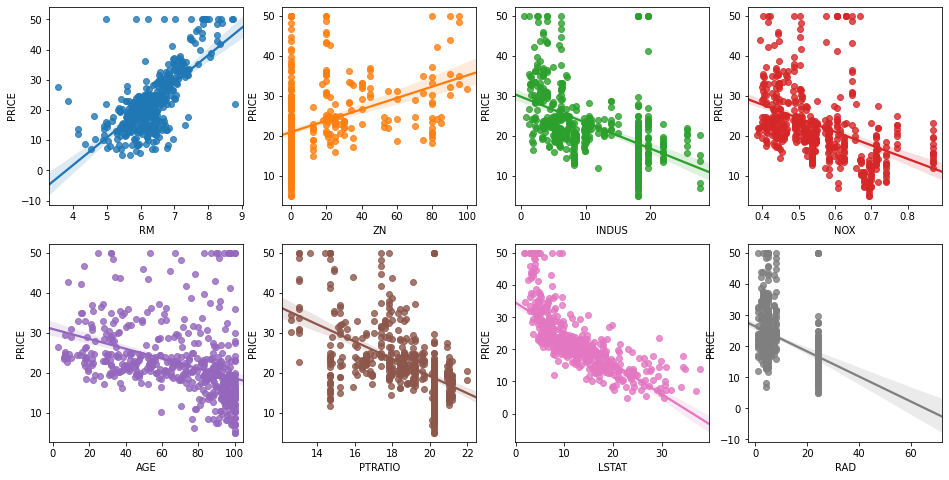

In [16]:
# 각 컬럼별로 PRICE(주택가격)에 미치는 영향도 조사
# 8개 col에 대해 값이 증가할 수록 PRICE가 어떻게 변하는지 확인

# matplotlib의 subplots() : 여러개의 그래프를 한번에 표현하기 위해 사용
# (ncols : 열 방향으로 위치할 그래프의 수, nrows : 행 방향으로 위치할 그래프의 수, 총 ncols*nrows개의 그래프를 그림)
# 아래는 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # seaborn의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])
    
# RM과 LSTAT의 PRICE 영향도가 가장 두드러지게 나타남
# RM은 양 방향의 선형성이 가장 큼. 즉, 방의 크기가 클수록 가격이 증가하는 모습
# LSTAT은 음 방향의 선형성이 가장 큼. 즉, 하위 계층의 비율이 적을수록 가격이 증가하는 모습

In [17]:
# 학습과 테스트 데이터 세트로 분리하고 학습/예측/평가 수행

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측 수행
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)

# 평균제곱오차(MSE, Mean squared error) : 수치가 작을 수록 원본과의 오차가 적은 것
mse = mean_squared_error(y_test, y_preds)

# 평균제곱근오차(RMSE, Root mean squared error) : 수치가 낮을수록 정확도가 높다고 판단
rmse = np.sqrt(mse)

print('MSE : {0:.3f}\nRMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

LinearRegression()

MSE : 17.297
RMSE : 4.159
Variance score : 0.757


In [18]:
print('절편 :',lr.intercept_)
print('회귀 계수 :', np.round(lr.coef_, 1))

절편 : 40.995595172164336
회귀 계수 : [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [19]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index 컬럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

# RM이 양의 값으로 회귀 계수가 가장 큼
# NOX의 회귀 계수 - 값이 상대적으로 너무 커 보임. 최적화 필요할 듯

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [20]:
#### Cross Validation 해보기

from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
# cross_val_score()의 인자로 scoring="neg_mean_squared_error"를 지정하면 반환되는 수치 값은 음수 값이므로 -1을 곱해서 양의 값으로
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores :  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 
